# Cliff Walking
### https://gymnasium.farama.org/environments/toy_text/cliff_walking/

# Dependencies

In [1951]:
from pathlib import Path
from typing import NamedTuple

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import gymnasium as gym

# Parameters we’ll use

In [1952]:
class Params(NamedTuple):
    total_episodes: int  # Total episodes
    learning_rate: float  # Learning rate
    gamma: float  # Discounting rate
    epsilon: float  # Exploration probability
    map_size_x: int  # Number of columns in the map
    map_size_y: int  # Number of rows in the map
    seed: int  # Define a seed so that we get reproducible results
    n_runs: int  # Number of runs
    action_size: int  # Number of possible actions
    state_size: int  # Number of possible states
    savefig_folder: Path  # Root folder where plots are saved

with open("config.json", "r") as file:
    config = json.load(file)

params = Params(
    total_episodes=config["total_episodes"],
    learning_rate=config["learning_rate"],
    gamma=config["gamma"],
    epsilon=config["epsilon"],
    map_size_x=config["map_size_x"],
    map_size_y=config["map_size_y"],
    seed=config["seed"],
    n_runs=config["n_runs"],
    action_size=None,
    state_size=None,
    savefig_folder=Path(config["savefig_folder"]),
)

np.random.seed(params.seed)

# Create the figure folder if it doesn't exist
params.savefig_folder.mkdir(parents=True, exist_ok=True)

# Cliff Walking environment

In [1953]:
env = gym.make("CliffWalking-v0", render_mode="rgb_array")
env.action_space.seed(params.seed)

1234

# Creating the Q-table
#### Q-learning as our learning algorithm and e-greedy to decide which action to pick at each step.

In [1954]:
params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)
print(f"Action size: {params.action_size}")
print(f"State size: {params.state_size}")


class QLearning:
    def __init__(self, learning_rate, gamma, epsilon, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.reset_q_table()

    def choose_action(self, action_space, state, qtable):
        if np.random.uniform(0, 1) < self.epsilon:
            # Exploration
            return action_space.sample()
        else:
            # Exploitation (taking the biggest Q value for this state)
            return np.argmax(qtable[state, :])

    def update(self, state, action, reward, new_state):
        delta = (
            reward
            + self.gamma * np.max(self.q_table[new_state, :])
            - self.q_table[state, action]
        )
        return self.q_table[state, action] + self.learning_rate * delta

    def reset_q_table(self):
        self.q_table = np.zeros((self.state_size, self.action_size))


    def train(self):
        rewards = np.zeros((params.total_episodes, params.n_runs))
        steps = np.zeros((params.total_episodes, params.n_runs))
        episodes = np.arange(params.total_episodes)
        q_tables = np.zeros((params.n_runs, params.state_size, params.action_size))
        all_states = []
        all_actions = []

        for run in range(params.n_runs):  # Run several times to account for stochasticity
            self.reset_q_table()  # Reset the Q-table between runs

            for episode in tqdm(
                episodes, desc=f"Run {run}/{params.n_runs} - Episodes", leave=False
            ):
                state = env.reset()[0]
                step = 0
                done = False
                total_rewards = 0

                while not done:

                    action = self.choose_action(
                        action_space=env.action_space, state=state, qtable=self.q_table
                    )

                    all_states.append(state)
                    all_actions.append(action)

                    new_state, reward, done, _, _ = env.step(action)
                    
                    self.q_table[state, action] = self.update(
                        state=state, action=action, reward=reward, new_state=new_state
                    )

                    total_rewards += reward
                    step += 1

                    state = new_state

                rewards[episode] = total_rewards
                steps[episode] = step

            q_tables[run, :, :] = self.q_table

        return rewards, steps, episodes, q_tables, all_states, all_actions


Action size: 4
State size: 48


# Running training

In [1955]:
learner = QLearning(
    learning_rate=params.learning_rate,
    gamma=params.gamma,
    epsilon=params.epsilon,
    state_size=params.state_size,
    action_size=params.action_size,
)

rewards, steps, episodes, q_tables, all_states, all_actions = learner.train()

# Visualization

In [1956]:
def qtable_directions_map(qtable, map_size_x, map_size_y):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size_x, map_size_y)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size_x, map_size_y)
    directions = {0: "↑", 1: "→", 2: "↓", 3: "←"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] < 0:
            # Assign an arrow only if a Q-value has been learned
            qtable_directions[idx] = directions[val]
            
    qtable_val_max[qtable_val_max == 0] = qtable_val_max.min()
    qtable_directions = qtable_directions.reshape(map_size_x, map_size_y)

    return qtable_val_max, qtable_directions

In [1957]:
def plot_q_values_map(qtable, env, map_size_x, map_size_y):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size_x, map_size_y)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    img_title = f"frozenlake_q_values_{map_size_x}x{map_size_y}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

In [1958]:
def plot_states_actions_distribution(states, actions, map_size_x, map_size_y):
    """Plot the distributions of states and actions."""
    labels = {"UP": 0, "RIGHT": 1, "DOWN": 2, "LEFT": 3}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.histplot(data=states, ax=ax[0], kde=True, bins=len(np.unique(states)))
    ax[0].set_title("States")
    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(list(labels.values()), labels=labels.keys())
    ax[1].set_title("Actions")
    fig.tight_layout()
    img_title = f"frozenlake_states_actions_distrib_{map_size_x}x{map_size_y}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

Map size: 4x12


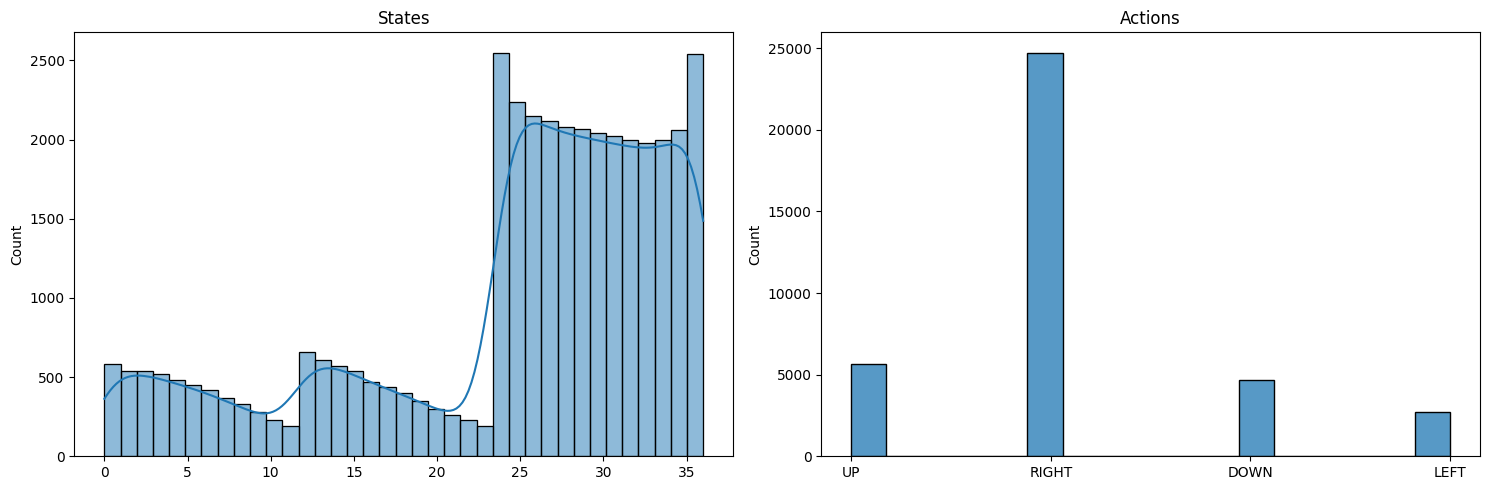

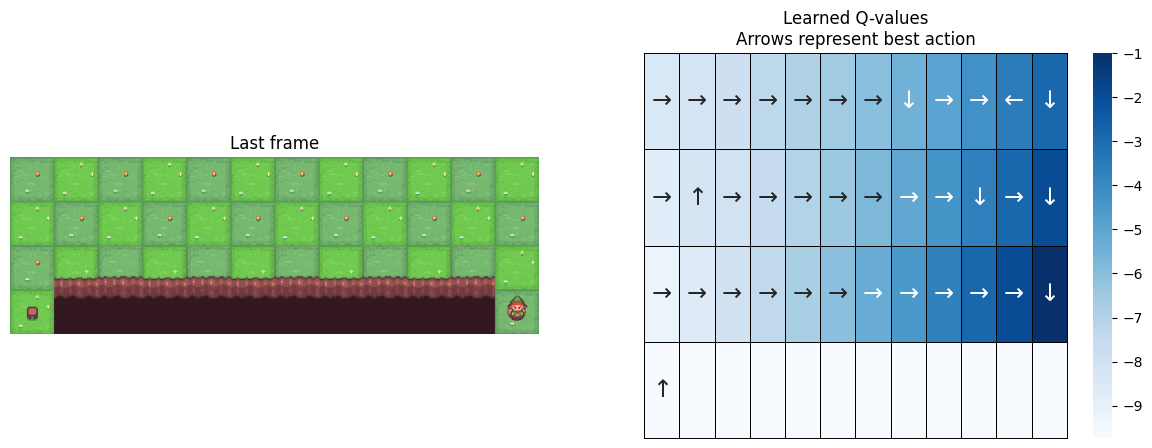

In [1959]:
print(f"Map size: {params.map_size_x}x{params.map_size_y}")

q_table = q_tables.mean(axis=0)  # Average the Q-table between runs

plot_states_actions_distribution(
    states=all_states, actions=all_actions, map_size_x=params.map_size_x, map_size_y=params.map_size_y
)  # Sanity check
plot_q_values_map(q_table, env, params.map_size_x, params.map_size_y)

env.close()

In [1960]:
def postprocess(episodes, rewards, steps, map_size_x, map_size_y):
    """Convert the results of the simulation in dataframes."""

    mean_rewards = rewards.mean(axis=1)
    cum_rewards = mean_rewards.cumsum()

    res = pd.DataFrame(
        data={
            "Episodes": episodes,
            "Rewards": mean_rewards,
            "cum_rewards": cum_rewards,
        }
    )
    res["map_size"] = np.repeat(f"{map_size_x}x{map_size_y}", res.shape[0])

    mean_steps = steps.mean(axis=1)
    st = pd.DataFrame(
        data={
            "Episodes": episodes,
            "Steps": mean_steps,
        }
    )
    st["map_size"] = np.repeat(f"{map_size_x}x{map_size_y}", st.shape[0])
    
    return res, st


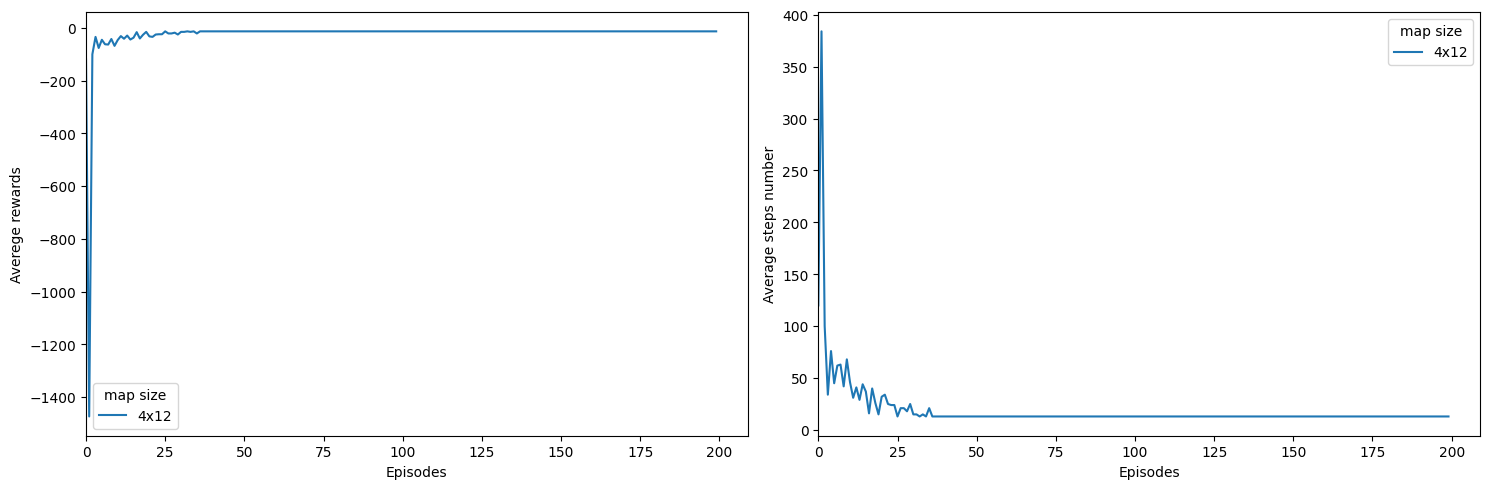

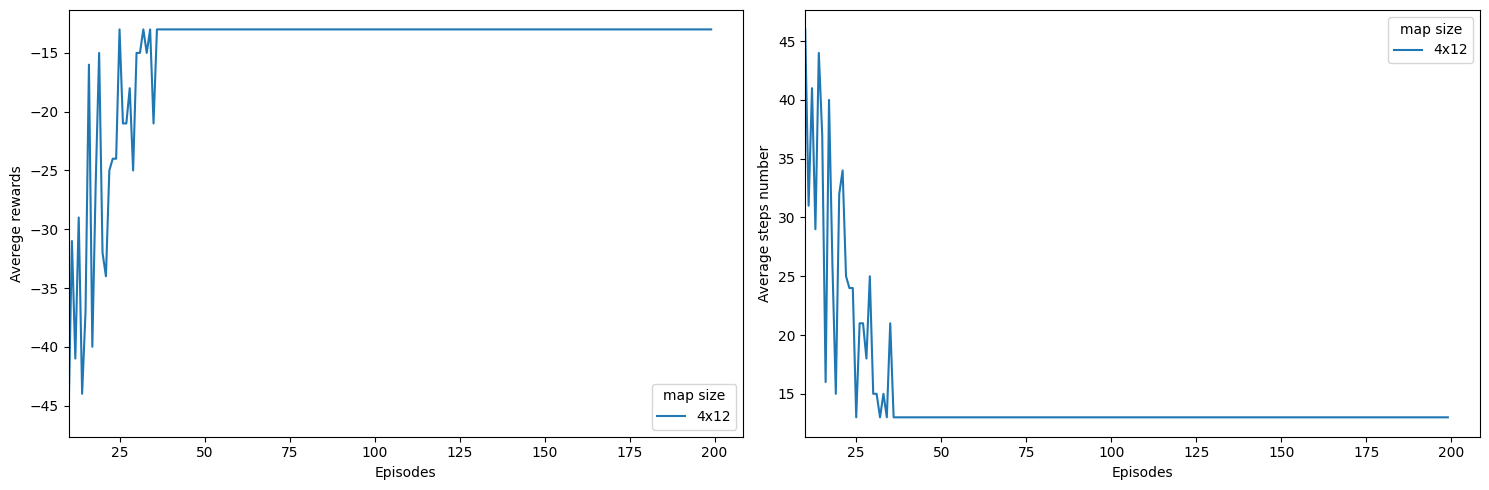

In [1961]:
def plot_rewards_and_steps(rewards_df, steps_df, start_episode=0):
    """Plot the steps and rewards from dataframes."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.lineplot(
        data=rewards_df[start_episode:], x="Episodes", y="Rewards", hue="map_size", ax=ax[0]
    )
    ax[0].set(ylabel="Averege rewards")
    ax[0].set_xlim(left=start_episode)

    sns.lineplot(data=steps_df[start_episode:], x="Episodes", y="Steps", hue="map_size", ax=ax[1])
    ax[1].set(ylabel="Average steps number")
    ax[1].set_xlim(left=start_episode)

    for axi in ax:
        axi.legend(title="map size")
    fig.tight_layout()
    img_title = f'frozenlake_rewards_and_steps{start_episode}.png'
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()


res_all = pd.DataFrame()
st_all = pd.DataFrame()

# Save the results in dataframes
res, st = postprocess(episodes, rewards, steps, params.map_size_x, params.map_size_y)

res_all = pd.concat([res_all, res])
st_all = pd.concat([st_all, st])

plot_rewards_and_steps(res_all, st_all)
plot_rewards_and_steps(res_all, st_all, config["start_episode"])